# Capstone Project : Anime Recommender System

# Contents

In this notebook, we will be covering the following:

1. [Content based filtering](#Content_based_filtering)
2. [Collaborative filtering](#Collaborative_filtering)
3. [Conclusion and next steps](#Conclusion_and_next_steps)

In [1]:
#!pip install surprise

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from PIL import image
from wordcloud import WordCloud
from typing import List, Dict, Tuple

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

import time
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

import surprise
from surprise import Reader, Dataset, BaselineOnly, SVD, SVDpp, NMF, KNNBaseline, KNNBasic, KNNWithMeans, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms.predictions import Prediction
#from surprise.modeL_selection.split import train_test_split


In [90]:
# Import datasets

anime_comb = pd.read_csv('../assets/anime_clean.csv')

display(anime_comb)

,anime_id_x,name,genre,type,episodes,rating,members,user_id,user_rating,anime_id_y,Score,Genres,synopsis
0,32281,Kimi no Na wa.,"['Drama', ' Romance', ' School', ' Supernatural']",Movie,1,9.37,200630,99,5,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1,32281,Kimi no Na wa.,"['Drama', ' Romance', ' School', ' Supernatural']",Movie,1,9.37,200630,152,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
2,32281,Kimi no Na wa.,"['Drama', ' Romance', ' School', ' Supernatural']",Movie,1,9.37,200630,244,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
3,32281,Kimi no Na wa.,"['Drama', ' Romance', ' School', ' Supernatural']",Movie,1,9.37,200630,271,10,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
4,32281,Kimi no Na wa.,"['Drama', ' Romance', ' School', ' Supernatural']",Movie,1,9.37,200630,278,-1,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7101629,6546,Pico: My Little Summer Story,['Yaoi'],OVA,1,5.21,5551,73389,6,6546,4.49,Yaoi,dited version of the first OVA titled pico~ Bo...
7101630,30663,Docchi mo Maid,"['Action', ' Comedy', ' Ecchi', ' Yuri']",ONA,1,5.15,223,12431,3,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7101631,30663,Docchi mo Maid,"['Action', ' Comedy', ' Ecchi', ' Yuri']",ONA,1,5.15,223,27364,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."
7101632,30663,Docchi mo Maid,"['Action', ' Comedy', ' Ecchi', ' Yuri']",ONA,1,5.15,223,48766,-1,30663,4.24,"Action, Comedy, Magic, Ecchi, Shoujo Ai","Izumi, a 12-year-old schoolgirl, suddenly gets..."


## Content based Recommender

Content Based recommendation relies on similarity of recommended elements / features. The idea is that if you liked an item, you will also like other items with similar features. The content based recommendation approach solves the cold start problem encountered in the collaborative based problem. For example, if a new item comes into the market, users will not be recommended that item due to it not having being rated. With content based recommendation, the item will have a good score if it ranks highly in terms of similarity to previously used or liked products.

### TFIDF Vectorizer

One feature we will be basing our content based recommender on is the synopsis feature, the idea being that if a user liked an anime with a certain 'style' of synopsis, they will also like other anime titles with a very similar synopsis. To give a score to our synopsis feature, we will be using TFIDF Vectorizer, which takes into account the frequency and weight /'importance' of the word in the document.

The output is a matrix whereby each column represents a word / n-gram and each row represents an observation or in our case, an anime title. This is done to reduce the importance of frequently occurring words in the synopsis and therefore their relevance to the calculation of the final similarity score.

In [4]:
%%time

# Drop duplicate animes with same name and keep first occurence
anime_dup = anime_comb.drop_duplicates(subset = 'name', keep = 'first')
anime_dup = anime_dup.reset_index(drop = True)

synopsis_str = anime_dup['synopsis'].str.split(',').astype(str)

tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 4), min_df = 3, stop_words = 'english')
tfidf_matrix = tfidf.fit_transform(synopsis_str)

tfidf_matrix.shape

# tfidf.get_feature_names()

Wall time: 3.07 s


(8844, 23217)

In [5]:
tfidf_matrix

<8844x23217 sparse matrix of type '<class 'numpy.float64'>'
	with 335051 stored elements in Compressed Sparse Row format>

In [6]:
tfidf.get_feature_names()

['00',
 '000',
 '000 000',
 '000 years',
 '000 years ago',
 '001',
 '007',
 '0079',
 '009',
 '01',
 '02',
 '03',
 '07',
 '09',
 '10',
 '10 000',
 '10 11',
 '10 minute',
 '10 minutes',
 '10 new',
 '10 new animated',
 '10 new animated versions',
 '10 year',
 '10 year old',
 '10 year old insect',
 '10 years',
 '10 years ago',
 '100',
 '100 000',
 '100 tv',
 '100 tv series',
 '100 years',
 '1000',
 '1000 years',
 '1001',
 '1001 nights',
 '100th',
 '100th anniversary',
 '101',
 '108',
 '108th',
 '10th',
 '10th anniversary',
 '10th anniversary event',
 '11',
 '11 12',
 '11 year',
 '11 year old',
 '11 years',
 '11th',
 '12',
 '12 000',
 '12 000 years',
 '12 year',
 '12 year old',
 '12 year old boy',
 '12 year old girl',
 '12 years',
 '12th',
 '12th birthday',
 '13',
 '13 14',
 '13 episode',
 '13 episodes',
 '13 included',
 '13 included blu',
 '13 included blu ray',
 '13 year',
 '13 year old',
 '13 year old boy',
 '13 years',
 '13 years old',
 '130',
 '13th',
 '13th episode',
 '13th episode tv

### Cosine Similarity

We will use cosine similarity to calculate a numerical value indicating the similarity between two anime. We use the cosine similarity index because it is magnitude independent and relatively easy and quick to calculate.

Cosine similarity takes the angle between two non-zero vectors and calculates the cosine of that angle, and this value is known as the similarity between the two vectors. This similarity score ranges from 0 to 1, where 0 is the lowest (least similar) and 1 is the highest (most similar). If the angle between two vectors is 0°, then the similarity will be 1. Conversely, if the angle between two vectors is 90°, then the similarity will be 0. For two vectors with an angle greater than 90°, we also consider them to be 0.

In [7]:
%%time
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim[:5, :5]

Wall time: 1.1 s


array([[1.        , 0.00536131, 0.01720987, 0.03505677, 0.00935462],
       [0.00536131, 1.        , 0.01010452, 0.00683776, 0.01263109],
       [0.01720987, 0.01010452, 1.        , 0.01135829, 0.00704835],
       [0.03505677, 0.00683776, 0.01135829, 1.        , 0.00874571],
       [0.00935462, 0.01263109, 0.00704835, 0.00874571, 1.        ]])

We now have a pairwise cosine similarity matrix for all the movies in the dataset. The next step is to write a function that returns the 10 most similar movies based on the cosine similarity score.

In [8]:
cosine_sim.shape

(8844, 8844)

##### Synopsis based recommendations

In [9]:
indices = pd.Series(anime_dup.index, index=anime_dup['name'])
indices

name
Kimi no Na wa.                         0
Fullmetal Alchemist: Brotherhood       1
Gintama°                               2
Steins;Gate                            3
Hunter x Hunter (2011)                 4
                                    ... 
G-Taste (2010)                      8839
Kimera                              8840
Houkago no Shokuinshitsu            8841
Pico: My Little Summer Story        8842
Docchi mo Maid                      8843
Length: 8844, dtype: int64

In [10]:
# Function to get recommendations using cosine similarity
def synop_recommendations(title):
    idx = indices[title]  # getting index corresponding with title
    sim_scores = list(enumerate(cosine_sim[idx]))  # get estimates of pairwise similarity of all animes with this anime
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # sorting from highest similarity score
    sim_scores = sim_scores[1:11]  # we use 1-11 as 0 will give us the anime that we have chosen
    
    anime_indices = [i[0] for i in sim_scores]  # get indexes
    similarity = [i[1] for i in sim_scores]
    
    return pd.DataFrame({'Anime name': anime_dup['name'].iloc[anime_indices].values,
                        'Similarity': similarity,
                         'Genre': anime_dup['genre'].iloc[anime_indices].values,
                        'Type': anime_dup['type'].iloc[anime_indices].values,
                        'Synopsis': anime_dup['synopsis'].iloc[anime_indices].values})  # displaying name, genre, type and synopsis

In [13]:
%%time
synop_recommendations('Fullmetal Alchemist: Brotherhood')

Wall time: 14 ms


,Anime name,Similarity,Genre,Type,Synopsis
0,Fullmetal Alchemist,0.621646,"['Action', ' Adventure', ' Comedy', ' Drama', ...",TV,"Edward Elric, a young, brilliant alchemist, ha..."
1,Fullmetal Alchemist: The Sacred Star of Milos,0.434367,"['Action', ' Adventure', ' Comedy', ' Drama', ...",Movie,Chasing a runaway alchemist with strange power...
2,Fullmetal Alchemist: The Sacred Star of Milos ...,0.319905,"['Comedy', ' Fantasy', ' Magic']",ONA,To mark the July 2 opening of the Fullmetal Al...
3,Fullmetal Alchemist: The Conqueror of Shamballa,0.304173,"['Comedy', ' Drama', ' Fantasy', ' Historical'...",Movie,"In desperation, Edward Elric sacrificed his bo..."
4,Fullmetal Alchemist: Brotherhood Specials,0.196841,"['Adventure', ' Drama', ' Fantasy', ' Magic', ...",Special,mazing secrets and startling facts are exposed...
5,Joker Game,0.087749,"['Drama', ' Historical', ' Military']",TV,"h World War II right around the corner, intell..."
6,Fullmetal Alchemist: Premium Collection,0.087326,"['Comedy', ' Fantasy', ' Shounen']",OVA,1. State Alchemists vs Seven Homunculi A 10 mi...
7,"Diabolik Lovers More,Blood",0.080114,"['Harem', ' School', ' Shoujo', ' Vampire']",TV,"Yui Komori, still held captive by the Sakamaki..."
8,Cowboy Bebop: Ein no Natsuyasumi,0.077855,['Adventure'],Special,Corgi can certainly dream! Taking a break from...
9,Inferious Wakusei Senshi Gaiden Condition Green,0.076809,"['Action', ' Sci-Fi']",OVA,"Keith, George, Edward, Yang and Shaw are Plato..."


In [14]:
%%time
synop_recommendations('Death Note')

Wall time: 8.98 ms


,Anime name,Similarity,Genre,Type,Synopsis
0,Soul Eater,0.176649,"['Action', ' Adventure', ' Comedy', ' Fantasy'...",TV,Death City is home to the famous Death Weapon ...
1,Kite Liberator,0.168902,"['Action', ' Drama', ' Sci-Fi']",OVA,"In the previous series ""Kite,"" a killer—Sawa—s..."
2,YAT Anshin! Uchuu Ryokou 2,0.164707,"['Adventure', ' Comedy', ' Sci-Fi', ' Shounen']",TV,"The space travelling company, YAT, is thrown i..."
3,Yami no Matsuei,0.163860,"['Comedy', ' Drama', ' Fantasy', ' Horror', ' ...",TV,"Even after death, life is full of paperwork an..."
4,Bleach: Memories in the Rain,0.145748,"['Action', ' Adventure', ' Drama', ' Shounen',...",Special,"Kurosaki Ichigo, the temporary Shinigami(Death..."
5,Medarot Damashii,0.139862,"['Action', ' Adventure', ' Sci-Fi']",TV,"The sequel to the famous Medabots series, foll..."
6,Yami no Shihosha Judge,0.133875,"['Horror', ' Seinen', ' Supernatural']",OVA,Hoichiro Ohma works in an office. Everybody kn...
7,Shinigami no Ballad.,0.132780,"['Drama', ' Fantasy', ' Psychological', ' Supe...",TV,"girl wrapped in white, her name is Momo...in h..."
8,Ghost Messenger,0.116069,"['Action', ' Fantasy']",OVA,Ghost Messengers are super-power agents from t...
9,Yume Senshi Wingman,0.115039,"['Action', ' Comedy', ' Romance', ' School', '...",TV,Hirono Kenta is your average geeky junior high...


The score does not seem too well, especially for 'Death Note', with the top recommended anime only having 17% similarity in synopsis. We will include 'genre' as another one of our features and see if that improves the result. 

##### Genre and synopsis based recommendations

Combining genres matrix with synopsis matrix

In [15]:
genres_str1 = anime_dup['genre'].astype(str)
# sypnopsis_str1 = anime_df['sypnopsis'].str.split(',').astype(str)
# unit =  pd.concat([sypnopsis_str1, genres_str1])

tfidf1 = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 1), min_df = 1)
tfidf_matrix1 = tfidf1.fit_transform(genres_str1)

tfidf_matrix1.shape

# # tfidf.get_feature_names()

(8844, 46)

In [16]:
tfidf1.get_feature_names()

['action',
 'adventure',
 'ai',
 'arts',
 'cars',
 'comedy',
 'dementia',
 'demons',
 'drama',
 'ecchi',
 'fantasy',
 'fi',
 'game',
 'harem',
 'historical',
 'horror',
 'josei',
 'kids',
 'life',
 'magic',
 'martial',
 'mecha',
 'military',
 'music',
 'mystery',
 'of',
 'parody',
 'police',
 'power',
 'psychological',
 'romance',
 'samurai',
 'school',
 'sci',
 'seinen',
 'shoujo',
 'shounen',
 'slice',
 'space',
 'sports',
 'super',
 'supernatural',
 'thriller',
 'vampire',
 'yaoi',
 'yuri']

In [17]:
genres_str1

0       ['Drama', ' Romance', ' School', ' Supernatural']
1       ['Action', ' Adventure', ' Drama', ' Fantasy',...
2       ['Action', ' Comedy', ' Historical', ' Parody'...
3                                 ['Sci-Fi', ' Thriller']
4       ['Action', ' Adventure', ' Shounen', ' Super P...
                              ...                        
8839                                   ['Ecchi', ' Yuri']
8840    ['Action', ' Horror', ' Sci-Fi', ' Supernatura...
8841                       ['Drama', ' Romance', ' Yaoi']
8842                                             ['Yaoi']
8843             ['Action', ' Comedy', ' Ecchi', ' Yuri']
Name: genre, Length: 8844, dtype: object

In [18]:
# Combining both dataframes
synop_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df = pd.DataFrame(tfidf_matrix1.toarray())
comb = pd.concat([synop_df, genre_df], axis = 1)
comb = csr_matrix(comb)
print(comb.shape)

(8844, 23263)


In [19]:
cosine_sim1 = cosine_similarity(comb, comb)
cosine_sim1[:5, :5]

array([[1.        , 0.07566103, 0.00860494, 0.01752839, 0.00467731],
       [0.07566103, 1.        , 0.09189383, 0.00341888, 0.17240756],
       [0.00860494, 0.09189383, 1.        , 0.11327186, 0.0986636 ],
       [0.01752839, 0.00341888, 0.11327186, 1.        , 0.00437286],
       [0.00467731, 0.17240756, 0.0986636 , 0.00437286, 1.        ]])

In [21]:
def synop_genre_recommendations(title):
    idx = indices[title]  # getting index corresponding with title
    sim_scores = list(enumerate(cosine_sim1[idx]))  # get estimates of pairwise similarity of all animes with this anime
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # sorting from highest similarity score
    sim_scores = sim_scores[1:11]  # we use 1-11 as 0 will give us the anime that we have chosen
    
    anime_indices = [i[0] for i in sim_scores]  # get indexes
    similarity = [i[1] for i in sim_scores]
    
    return pd.DataFrame({'Anime name': anime_dup['name'].iloc[anime_indices].values,
                        'Similarity': similarity,
                         'Genre': anime_dup['genre'].iloc[anime_indices].values,
                        'Type': anime_dup['type'].iloc[anime_indices].values,
                        'Synopsis': anime_dup['synopsis'].iloc[anime_indices].values})  # displaying name, genre, type and synopsis

In [24]:
synop_genre_recommendations('Fullmetal Alchemist: Brotherhood')

,Anime name,Similarity,Genre,Type,Synopsis
0,Fullmetal Alchemist,0.797745,"['Action', ' Adventure', ' Comedy', ' Drama', ...",TV,"Edward Elric, a young, brilliant alchemist, ha..."
1,Fullmetal Alchemist: The Sacred Star of Milos,0.704106,"['Action', ' Adventure', ' Comedy', ' Drama', ...",Movie,Chasing a runaway alchemist with strange power...
2,Fullmetal Alchemist: Brotherhood Specials,0.576796,"['Adventure', ' Drama', ' Fantasy', ' Magic', ...",Special,mazing secrets and startling facts are exposed...
3,Fullmetal Alchemist: The Conqueror of Shamballa,0.479923,"['Comedy', ' Drama', ' Fantasy', ' Historical'...",Movie,"In desperation, Edward Elric sacrificed his bo..."
4,Tales of Vesperia: The First Strike,0.443175,"['Action', ' Adventure', ' Fantasy', ' Magic',...",Movie,Ten years after the Great War against the demo...
5,Tide-Line Blue,0.426710,"['Action', ' Adventure', ' Drama', ' Military'...",TV,"The catastrophe, ""Hammer of Eden,"" resulted in..."
6,Fullmetal Alchemist: The Sacred Star of Milos ...,0.416856,"['Comedy', ' Fantasy', ' Magic']",ONA,To mark the July 2 opening of the Fullmetal Al...
7,Fullmetal Alchemist: Reflections,0.406139,"['Adventure', ' Comedy', ' Drama', ' Fantasy',...",Special,flection on what happened during the FMA TV se...
8,Magi: Sinbad no Bouken (TV),0.399622,"['Action', ' Adventure', ' Fantasy', ' Magic',...",TV,"In the small, impoverished Tison Village of th..."
9,Fairy Tail Movie 1: Houou no Miko,0.399445,"['Action', ' Adventure', ' Comedy', ' Fantasy'...",Movie,In the mountains of north Fiore lies the Fire ...


In [25]:
synop_genre_recommendations('Death Note')

,Anime name,Similarity,Genre,Type,Synopsis
0,Mousou Dairinin,0.502951,"['Drama', ' Mystery', ' Police', ' Psychologic...",TV,The infamous Shounen Bat (Lil' Slugger) is ter...
1,Higurashi no Naku Koro ni Kai,0.439441,"['Mystery', ' Psychological', ' Supernatural',...",TV,"In the small village of Hinamizawa, Rika Furud..."
2,Higurashi no Naku Koro ni Rei,0.435465,"['Comedy', ' Mystery', ' Psychological', ' Sup...",OVA,The infamous series of unexplainable murders i...
3,Monster,0.410825,"['Drama', ' Horror', ' Mystery', ' Police', ' ...",TV,"Dr. Kenzou Tenma, an elite neurosurgeon recent..."
4,Higurashi no Naku Koro ni,0.404385,"['Horror', ' Mystery', ' Psychological', ' Sup...",TV,Keiichi Maebara has just moved to the quiet li...
5,Mirai Nikki (TV): Ura Mirai Nikki,0.399226,"['Action', ' Comedy', ' Mystery', ' Psychologi...",Special,"Unaired ""Ura Mirai Nikki"" anime (the short epi..."
6,AD Police,0.389150,"['Adventure', ' Dementia', ' Mecha', ' Mystery...",OVA,"The year is 2027 in MegaTokyo, six years befor..."
7,Imawa no Kuni no Alice (OVA),0.383433,"['Action', ' Psychological', ' Shounen', ' Sup...",OVA,ouhei Arisu is a high school student with no a...
8,Shigofumi,0.383216,"['Drama', ' Fantasy', ' Psychological', ' Supe...",TV,There are some things that people are unable t...
9,Zankyou no Terror,0.380111,"['Psychological', ' Thriller']",TV,"Painted in red, the word ""VON"" is all that is ..."


We see that by adding genre to the list of features, the similarity score has improved. The anime recommendations also seemed better. Perhaps more features such as voice actors/actresses and animation studio will further improve the score. But one shortcoming of content based recommender is that it does not take into account user ratings when recommending anime titles, hence we will look into another approach when doing recommender systems, the collaborative based filtering approach.

## Collaborative based Filtering

Collaborative Filtering doesn’t need anything else except users’ historical preference on a set of items. Because it’s based on historical data, the core assumption here is that the users who have agreed in the past tend to also agree in the future.

Collaborative filtering is used by most recommendation systems to find similar patterns or information of the users, this technique can filter out items that users like on the basis of the ratings or reactions by similar users.

An example of collaborative filtering can be to predict the rating of a particular user based on user ratings for other animes and others’ ratings for all animes. This concept is widely used in recommending movies, news, applications, and many other items.

There are two sub-categories in collaborative filtering, namely memory based and model based.

Memory-based techniques rely heavily on simple similarity measures (Cosine similarity, Pearson correlation, Jaccard coefficient etc) to match similar people or items together. It is considered a more memory intensive method compared to model based techniques.

Model-based techniques on the other hand try to further fill out this matrix. They tackle the task of “guessing” how much a user will like an item that they did not encounter before. For that they utilize several machine learning algorithms to train on the vector of items for a specific user, then they can build a model that can predict the user’s rating for a new item that has just been added to the system.

We will be using a pre trained library called the SURPRISE recommender library, which includes pre trained models for memory based and model based techniques. We will be using five models to predict user ratings and from the ratings, provide recommendations for anime that the user has not watched before. 

https://surprise.readthedocs.io/en/stable/index.html

- Surprise library
    - Memory Based 
        - KNNBasic
        - KNNWithMeans
    - Model Based
        - BaselineOnly
        - SVD
        - NMF

In [31]:
# Making copy of anime_comb
anime_feature = anime_comb.copy()

# Filling -1 user ratings scores as null
anime_feature["user_rating"].replace({-1: np.nan}, inplace=True)
anime_feature.head()

,Unnamed: 0,anime_id_x,name,genre,type,episodes,rating,members,user_id,user_rating,anime_id_y,Score,Genres,synopsis
0,0,32281,Kimi no Na wa.,"['Drama', ' Romance', ' School', ' Supernatural']",Movie,1,9.37,200630,99,5.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
1,1,32281,Kimi no Na wa.,"['Drama', ' Romance', ' School', ' Supernatural']",Movie,1,9.37,200630,152,10.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
2,2,32281,Kimi no Na wa.,"['Drama', ' Romance', ' School', ' Supernatural']",Movie,1,9.37,200630,244,10.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
3,3,32281,Kimi no Na wa.,"['Drama', ' Romance', ' School', ' Supernatural']",Movie,1,9.37,200630,271,10.0,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."
4,4,32281,Kimi no Na wa.,"['Drama', ' Romance', ' School', ' Supernatural']",Movie,1,9.37,200630,278,NaN,32281,8.96,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to l..."


Due to memory constraints, we will be reducing the size of our data by taking into account only user who has given 200 and more ratings.

In [32]:
#Filtering out users who have given more than or equal to 200 ratings
counts = anime_feature['user_id'].value_counts()
anime_feature = anime_feature[anime_feature['user_id'].isin(counts[counts >= 200].index)]

In [33]:
# Dropping nulls since to reduce size of dataset since rows without ratings does not help with recommendation
anime_feature = anime_feature.dropna(axis = 0, how ='any') 
anime_feature.isnull().sum()

Unnamed: 0     0
anime_id_x     0
name           0
genre          0
type           0
episodes       0
rating         0
members        0
user_id        0
user_rating    0
anime_id_y     0
Score          0
Genres         0
synopsis       0
dtype: int64

In [35]:
anime_feature['user_rating'].value_counts()

8.0     756451
7.0     672569
9.0     496660
10.0    326277
6.0     326078
5.0     145887
4.0      54490
3.0      22051
2.0      11565
1.0       7830
Name: user_rating, dtype: int64

We are further reducing our data to 100,000 random samples due to memory constraints. We have plotted a histogram of our user ratings below and they are largely similar to the bigger dataset.

Surprise recommender library requires that our data be arranged in the format of (user_id, item_id, user_rating).

In [36]:
# Define reader
reader = Reader(rating_scale=(1, 10))

# Reducing number of rows for surprise library to random 100_000 rows
surprise_rating_df = anime_feature.sample(n = 100_000, random_state = 42) 
surprise_rating_df

# Match user_id, anime_id and ratings in order
data = Dataset.load_from_df(surprise_rating_df[['user_id', 'anime_id_x', 'user_rating']], reader)

# Initialising train test set
trainset = data.build_full_trainset()
testset = trainset.build_testset()

In [37]:
# Function to predict top 10 animes recommendations
def get_top_n(predictions: List[Prediction], n: int=10
                              ) -> Dict[int, List[Tuple[int, float]]]:
    """
    Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(List[Prediction]): The list of predictions, as 
        returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. 
        Default is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
      # add to users list the item id and its estimated rating
      top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
      # sort users item prediction by estimated rating
      user_ratings.sort(key=lambda x: x[1], reverse=True)
      # slice only top n
      top_n[uid] = user_ratings[:n]
    
    return top_n

We will be using a threshold score of 7 for the recommendation to be considered as relevant to the user as this seems to be the average score that users tend to rate their animes.

In [38]:
# Function for getting precision and recall of model
def precision_recall_at_k(predictions, k=10, threshold= 7):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    # Predictions: Traz uma lista de 5 campos dentro de uma tupla com as seguintes infos: User_ID, Item_ID, True_ID, Est_ID, Details
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    # Creates a dict with the key being a user and the value bringing the estimated rating and the true rating.

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k /  n_rel if n_rel != 0 else 1

    return precisions, recalls

In [39]:
# Returns the precision and recall of the model at k metrics
def get_precision_vs_recall(algo, k_max = 10, verbose = False):
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    if algo:
        for k_curr in range(1, k_max + 1):
            algo.fit(trainset)
            predictions = algo.test(testset)
            
            # Get precision and recall at k metrics for each user
            precisions, recalls = precision_recall_at_k(predictions, k = k_curr, threshold = 7)
            
            # Precision and recall can then be averaged over all users
            precision = sum(prec for prec in precisions.values()) / len(precisions)
            recall = sum(rec for rec in recalls.values()) / len(recalls)
            f1_score = 2 * (precision * recall) / (precision + recall)
            
            # Save measures
            precision_list.append(precision)
            recall_list.append(recall)
            f1_score_list.append(f1_score)
            
            if verbose:
                print('K =', k_curr, '- Precision:', precision, ', Recall:', recall, ', F1 score:', f1_score)
    
    return {'precision': precision_list, 'recall': recall_list, 'f1_score': f1_score_list};

(array([  267.,   405.,   804.,  1858.,  5121., 11559., 23937., 26799.,
        17524., 11726.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

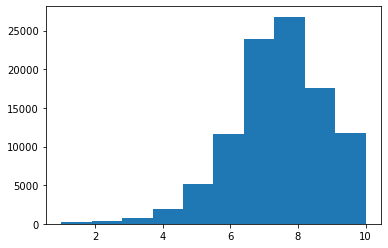

In [46]:
plt.hist(surprise_rating_df['user_rating'], bins = 10)

### Memory Based

We will use GridsearchCV in SURPRISE recommender to compute the best parameters before comparing each of the model's best scores to get our best model for prediction of user ratings.

#### KNNBasic (GridsearchCV)

In [47]:
%%time
# GridSearchCV with KNNBasic

param_grid = {'k':[5,10], 
              'min_k': [3, 5],
              'sim_options': {'name': ['pearson', 'cosine'],
              'min_support': [1, 5],
              'user_based': [True, False]}
             }

# sim_options = {'name': 'pearson', 'user_based':True}

gs1 = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv = 5)

gs1.fit(data)

# best RMSE score
print(gs1.best_score)#['rmse'])

# parameters with best rmse score
print(gs1.best_params)#['rmse'])

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done comput

In [48]:
# Testing on best model - KNNBasic
algo1 = KNNBasic(k = 10, min_k = 3, sim_options = {'name': 'cosine', 'min_support': 1, 'user_based': False})
# algo1.fit(data.build_full_trainset())

# Calculate the precision and recall of the model at k metrics
k_max = 10
metrics = get_precision_vs_recall(algo1, k_max, True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
K = 1 - Precision: 0.9542505592841163 , Recall: 0.1440055637735923 , F1 score: 0.25024652608060943
Computing the cosine similarity matrix...
Done computing similarity matrix.
K = 2 - Precision: 0.9396532438478747 , Recall: 0.2526125609814607 , F1 score: 0.398180022276033
Computing the cosine similarity matrix...
Done computing similarity matrix.
K = 3 - Precision: 0.9310029828486304 , Recall: 0.3464306914840146 , F1 score: 0.5049624314787627
Computing the cosine similarity matrix...
Done computing similarity matrix.
K = 4 - Precision: 0.9241051454138719 , Recall: 0.4292791578923504 , F1 score: 0.5862327169868116
Computing the cosine similarity matrix...
Done computing similarity matrix.
K = 5 - Precision: 0.9185458612975663 , Recall: 0.5015422020146818 , F1 score: 0.6488182329370904
Computing the cosine similarity matrix...
Done computing similarity matrix.
K = 6 - Precision: 0.9146010439970099 , Recall: 0.5643

#### KNNWithMeans (GridSearchCV)

In [51]:
%%time
# GridSearchCV with KNNWithMeans

# param_grid = {'k':[5,10], 
#               'k-int': [3, 5],
#              }

param_grid = {'k': [10, 20],
              'min_k':[3, 5],
              'sim_options': {'name': ['pearson', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [True, False]}
              }
# sim_options = {'name': 'pearson', 'user_based':True}

gs2 = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv = 5)

gs2.fit(data)

# best RMSE score
print(gs2.best_score)#['rmse'])

# parameters with best rmse score
print(gs2.best_params)#['rmse'])

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done comput

In [52]:
# Testing on best model - KNNWithMeans
algo2 = KNNWithMeans(k = 20, min_k = 3, sim_options = {'name': 'cosine', 'min_support': 1, 'user_based': True})
# algo1.fit(data.build_full_trainset())

# Calculate the precision and recall of the model at k metrics
k_max = 10
metrics = get_precision_vs_recall(algo2, k_max, True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
K = 1 - Precision: 0.9658836689038032 , Recall: 0.16019276049564524 , F1 score: 0.2748082940016431
Computing the cosine similarity matrix...
Done computing similarity matrix.
K = 2 - Precision: 0.9583333333333334 , Recall: 0.27897757979480464 , F1 score: 0.4321525190367953
Computing the cosine similarity matrix...
Done computing similarity matrix.
K = 3 - Precision: 0.9526286353467657 , Recall: 0.3796504785621895 , F1 score: 0.5429281500034991
Computing the cosine similarity matrix...
Done computing similarity matrix.
K = 4 - Precision: 0.9471383296047745 , Recall: 0.46571768125007595 , F1 score: 0.624407672540839
Computing the cosine similarity matrix...
Done computing similarity matrix.
K = 5 - Precision: 0.9415566741238077 , Recall: 0.5379136132934043 , F1 score: 0.6846722871097864
Computing the cosine similarity matrix...
Done computing similarity matrix.
K = 6 - Precision: 0.9357475764354904 , Recall: 0.59

### Model Based

#### Matrix Factorization models

Factorization is the method of expressing something big as a product of smaller factors.

Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. It finds two rectangular matrices with smaller dimensions to represent a big rating matrix (RM). These factors retain the dependencies and properties of the rating matrix. 

#### BaselineOnly (GridSearchCV)

In [64]:
%%time
# GridSearchCV with BaselineOnly

param_grid = {'bsl_options':{'method': ['als', 'sgd'],
                             'n_epochs': [5, 10],
                             'reg_u': [12],
                             'reg_i': [5],
                            'lr_all':[0.005, 0.01],
                            'reg_all':[0.04, 0.05]}
               }
                             

gs3 = GridSearchCV(BaselineOnly, param_grid,  measures=['rmse', 'mae'], cv = 5)

gs3.fit(data)

# best RMSE score
print(gs3.best_score)#['rmse'])

# parameters with best rmse score
print(gs3.best_params)#['rmse'])


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

In [65]:
# Testing on best model - BaselineOnly
algo3 = BaselineOnly(bsl_options = {'method':'als', 'n_epochs':10, 'reg_u':12, 'reg_i':5,
                               'lr_all':0.005, 'reg_all':0.04})
# algo1.fit(data.build_full_trainset())

# Calculate the precision and recall of the model at k metrics
k_max = 10
metrics = get_precision_vs_recall(algo3, k_max, True)

Estimating biases using als...
K = 1 - Precision: 0.9522371364653244 , Recall: 0.17400320498567823 , F1 score: 0.29423970630972035
Estimating biases using als...
K = 2 - Precision: 0.9418903803131992 , Recall: 0.3086234456380151 , F1 score: 0.464912020248068
Estimating biases using als...
K = 3 - Precision: 0.9323266219239503 , Recall: 0.42370895643441253 , F1 score: 0.582632412210974
Estimating biases using als...
K = 4 - Precision: 0.9217095451155873 , Recall: 0.5221893135802006 , F1 score: 0.666676716011773
Estimating biases using als...
K = 5 - Precision: 0.9132811334825017 , Recall: 0.6051602268791662 , F1 score: 0.7279588561932917
Estimating biases using als...
K = 6 - Precision: 0.9061372110365336 , Recall: 0.6741379979376076 , F1 score: 0.7731077749444489
Estimating biases using als...
K = 7 - Precision: 0.8995962501331679 , Recall: 0.7295422527424861 , F1 score: 0.8056938973849012
Estimating biases using als...
K = 8 - Precision: 0.8942291200596598 , Recall: 0.7729111521318598

#### Singular Value Decomposition - SVD (GridSearchCV)

In [66]:
%%time
# GridSearchCV with SVD - Singular value decomposition

param_grid = {'n_factors':[20,50], 'n_epochs': [50, 75], 'lr_all': [0.01, 0.05], 'reg_all': [0.4, 0.5]}

gs4 = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv = 5)

gs4.fit(data)

# best RMSE score
print(gs4.best_score)#['rmse'])

# parameters with best rmse score
print(gs4.best_params)#['rmse'])

{'rmse': 1.2771907256038806, 'mae': 0.9756156705192449}
{'rmse': {'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.4}, 'mae': {'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.4}}
Wall time: 11min 5s


In [67]:
# Testing on best model - SVD
algo4 = SVD(n_factors = 20, n_epochs = 50, lr_all = 0.01, reg_all = 0.4, random_state = 42)
# algo1.fit(data.build_full_trainset())

# Calculate the precision and recall of the model at k metrics
k_max = 10
metrics = get_precision_vs_recall(algo4, k_max, True)

K = 1 - Precision: 0.9710290827740492 , Recall: 0.1718226830849313 , F1 score: 0.2919798128505922
K = 2 - Precision: 0.962248322147651 , Recall: 0.3005754219996001 , F1 score: 0.4580658177174914
K = 3 - Precision: 0.9557606263982199 , Recall: 0.4106551123198849 , F1 score: 0.5744781419931461
K = 4 - Precision: 0.9473900074571238 , Recall: 0.504325686874361 , F1 score: 0.6582461264479801
K = 5 - Precision: 0.9404828486204542 , Recall: 0.5837370416794664 , F1 score: 0.7203615164685402
K = 6 - Precision: 0.934326994780009 , Recall: 0.6496310805904945 , F1 score: 0.7663938391826826
K = 7 - Precision: 0.9290510812826325 , Recall: 0.70336648428134 , F1 score: 0.8006081367223982
K = 8 - Precision: 0.9244829285181679 , Recall: 0.7458125730868694 , F1 score: 0.8255916285836447
K = 9 - Precision: 0.9206254216824546 , Recall: 0.7789186109388885 , F1 score: 0.8438643081767021
K = 10 - Precision: 0.9171715315507215 , Recall: 0.8041788155708892 , F1 score: 0.8569666449960515


#### Non negative Matrix Factorization - NMF (GridSearchCV)

In [69]:
%%time
# GridSearchCV with NMF - Non negative matrix factorization

param_grid = {'n_factors':[50, 75], 'n_epochs': [50, 75]}

gs5 = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv = 5)

gs5.fit(data)

# best RMSE score
print(gs5.best_score)#['rmse'])

# parameters with best rmse score
print(gs5.best_params)#['rmse'])

{'rmse': 1.6946556879268395, 'mae': 1.3595303733585422}
{'rmse': {'n_factors': 50, 'n_epochs': 75}, 'mae': {'n_factors': 50, 'n_epochs': 50}}
Wall time: 6min


In [70]:
# Testing on best model - NMF
algo5 = NMF(n_factors = 50, n_epochs = 75, random_state = 42)
# algo1.fit(data.build_full_trainset())

# Calculate the precision and recall of the model at k metrics
k_max = 10
metrics = get_precision_vs_recall(algo5, k_max, True)

K = 1 - Precision: 1.0 , Recall: 0.16931193829266009 , F1 score: 0.2895924222579587
K = 2 - Precision: 1.0 , Recall: 0.2887061953175255 , F1 score: 0.4480558817308873
K = 3 - Precision: 1.0 , Recall: 0.38064372350891884 , F1 score: 0.5514003606107871
K = 4 - Precision: 1.0 , Recall: 0.4512881380663101 , F1 score: 0.6219139070034768
K = 5 - Precision: 1.0 , Recall: 0.5034112666755224 , F1 score: 0.6696920235122495
K = 6 - Precision: 1.0 , Recall: 0.5408420564488032 , F1 score: 0.7020084299818351
K = 7 - Precision: 1.0 , Recall: 0.5673444467231106 , F1 score: 0.7239563044476572
K = 8 - Precision: 0.9999860178970917 , Recall: 0.5860726995960193 , F1 score: 0.73901993489061
K = 9 - Precision: 0.9999875714640815 , Recall: 0.59918059614692 , F1 score: 0.7493560231435376
K = 10 - Precision: 0.9999888143176734 , Recall: 0.6084532683338224 , F1 score: 0.7565662064322966


#### Model Evaluation

| |RMSE|MAE|MAP@10|MAR@10|F1@10|
|---|---|---|---|---|---|
|**KNNBasic**|1.519|1.176|0.901|0.719|0.800|
|**KNNWithMeans**|1.406|1.066|0.922|0.735|0.818|
|**BaselineOnly**|1.302|0.996|0.886|0.832|0.858|
|**SVD**|1.276|0.976|0.917|0.804|0.856|
|**NMF (Non Negative MF)**|1.692|1.360|0.999|0.608|0.756|

We can see that SVD model performs the best in terms of RMSE score but BaselineOnly model has the best MAP@10 score. As the MAP@10 is only marginally different across BaselineOnly and SVD, we will be using SVD as our final model of choice. Coincidentally, SVD algorithm is also a hugely popular model used in the Netflix $1 million challenge.

### Using best model - SVD

In [72]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(surprise_rating_df[['user_id', 'anime_id_x', 'user_rating']], reader)

In [73]:
# Testing on best model - SVD
algo = SVD(n_factors = 20, n_epochs = 50, lr_all = 0.01, reg_all = 0.4, random_state = 42)
algo.fit(data.build_full_trainset())

In [74]:
# Calculate the precision and recall of the model at k metrics
k_max = 11
metrics = get_precision_vs_recall(algo, k_max, True)

K = 1 - Precision: 0.9710290827740492 , Recall: 0.1718226830849313 , F1 score: 0.2919798128505922
K = 2 - Precision: 0.962248322147651 , Recall: 0.3005754219996001 , F1 score: 0.4580658177174914
K = 3 - Precision: 0.9557606263982199 , Recall: 0.4106551123198849 , F1 score: 0.5744781419931461
K = 4 - Precision: 0.9473900074571238 , Recall: 0.504325686874361 , F1 score: 0.6582461264479801
K = 5 - Precision: 0.9404828486204542 , Recall: 0.5837370416794664 , F1 score: 0.7203615164685402
K = 6 - Precision: 0.934326994780009 , Recall: 0.6496310805904945 , F1 score: 0.7663938391826826
K = 7 - Precision: 0.9290510812826325 , Recall: 0.70336648428134 , F1 score: 0.8006081367223982
K = 8 - Precision: 0.9244829285181679 , Recall: 0.7458125730868694 , F1 score: 0.8255916285836447
K = 9 - Precision: 0.9206254216824546 , Recall: 0.7789186109388885 , F1 score: 0.8438643081767021
K = 10 - Precision: 0.9171715315507215 , Recall: 0.8041788155708892 , F1 score: 0.8569666449960515
K = 11 - Precision: 0.91

In [75]:
# get a unique user
user_id = surprise_rating_df.user_id.iloc[5000]

# get all unique anime's
anime_ids = surprise_rating_df.anime_id_x.unique()

# create a user data frame to predict ratings
user_to_predict = {'user_id': [user_id] * len(anime_ids),
                   'anime_id_x': anime_ids,
                   'user_rating': [0] * len(anime_ids)}
predict_data_df = pd.DataFrame(user_to_predict)

# create data object from dataframe
reader = Reader(rating_scale=(1, 10))
predict_data = Dataset.load_from_df(predict_data_df, reader)

# predict ratings
testset = predict_data.build_full_trainset().build_testset()
predictions = algo.test(testset)

# get top 10
top_n = get_top_n(predictions, n=10)

print('Model Used: SVD\n')

for uid, user_ratings in top_n.items():
    print(f"User id: {uid}\n")
    print(f"Top N Recommendations (User's animes not included):")
    names = [surprise_rating_df.loc[surprise_rating_df.anime_id_x == iid,
            'name'].iloc[0] for (iid, _) in user_ratings]
    for i in names:
        print(i)

print(f"\nUser's Animes:")
names = surprise_rating_df[surprise_rating_df.user_id == user_id].sort_values(
    by='user_rating', ascending = False).name.to_list()
for i in names[:10]:
    print(i)

Model Used: SVD

User id: 65108

Top N Recommendations (User's animes not included):
Ginga Eiyuu Densetsu
Gintama°
Gintama: Yorinuki Gintama-san on Theater 2D
One Piece: Episode of Merry - Mou Hitori no Nakama no Monogatari
Kimi no Na wa.
Gintama
Romeo no Aoi Sora
Yojouhan Shinwa Taikei
Tamala 2010: A Punk Cat in Space
Kaguya-hime no Monogatari

User's Animes:
Top wo Nerae! Gunbuster
Kamisama Hajimemashita
Kyoukai no Kanata
Sidonia no Kishi
Mobile Suit Zeta Gundam: A New Translation III - Love Is the Pulse of the Stars
Date A Live: Date to Date
Shigatsu wa Kimi no Uso
Shaman King
Hamatora The Animation
Air in Summer


We have predicted a list of top animes that a user has not watched based on ratings for animes that he has watched. While there are no metrics to prove if this a good recommendation, a brief look into these animes in www.myanimelist.net will show that these animes are very similar in terms of genre and have generally been rated highly.

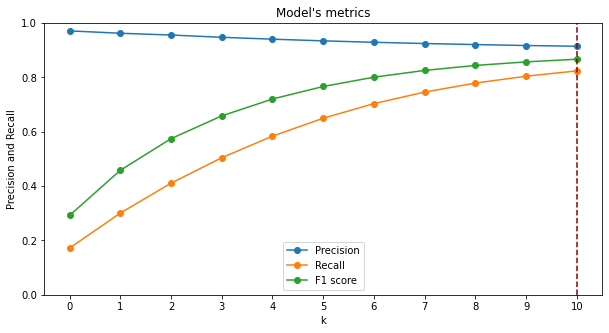

In [76]:
# Get data
c1 = metrics['precision']
c2 = metrics['recall']
c3 = metrics['f1_score']
x = np.arange(len(c1))

# Set up the matplotlib figure
fig, ax1 = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 2, 1.0))
plt.ylim(0, 1)
ax1.plot(x, c1, marker = 'o')
ax1.plot(x, c2, marker = 'o')
ax1.plot(x, c3, marker = 'o')
ax1.axvline(x = 10, color = "#8b0000", linestyle = "--")

# Chart setup
plt.title("Model's metrics", fontsize = 12)
plt.xlabel("k", fontsize = 10)
plt.ylabel("Precision and Recall", fontsize = 10)
plt.legend(("Precision", "Recall", "F1 score"), loc = "best")
plt.draw()

We have a look into the precision and recall vs k to conclude that our best 'k' is at 10.

In [87]:
# get a unique user
user_id = surprise_rating_df.user_id.iloc[2500]

# get all unique anime's
anime_ids = surprise_rating_df.anime_id_x.unique()

# create a user data frame to predict ratings
user_to_predict = {'user_id': [user_id] * len(anime_ids),
                   'anime_id_x': anime_ids,
                   'user_rating': [0] * len(anime_ids)}
predict_data_df = pd.DataFrame(user_to_predict)

# create data object from dataframe
reader = Reader(rating_scale=(1, 10))
predict_data = Dataset.load_from_df(predict_data_df, reader)

# predict ratings
testset = predict_data.build_full_trainset().build_testset()
predictions = algo.test(testset)

# get top 10
top_n = get_top_n(predictions, n=10)

print('Model Used: SVD\n')

for uid, user_ratings in top_n.items():
    print(f"User id: {uid}\n")
    print(f"Top N Recommendations (User's animes not included):")
    names = [surprise_rating_df.loc[surprise_rating_df.anime_id_x == iid,
            'name'].iloc[0] for (iid, _) in user_ratings]
    for i in names:
        print(i)

print(f"\nUser's Animes:")
names = surprise_rating_df[surprise_rating_df.user_id == user_id].sort_values(
    by='user_rating', ascending = False).name.to_list()
for i in names[:10]:
    print(i)

Model Used: SVD

User id: 22479

Top N Recommendations (User's animes not included):
Mobile Suit Gundam
Yojouhan Shinwa Taikei
Seikai no Senki
Romeo no Aoi Sora
Kaze Tachinu
Doraemon
Project A-Ko 4: Final
Mobile Suit Zeta Gundam: A New Translation - Heir to the Stars
Digimon Adventure: Bokura no War Game!
Zetsuen no Tempest

User's Animes:
Clannad
Hajime no Ippo: Rising
Gintama: Shinyaku Benizakura-hen
Diamond no Ace
Ao no Exorcist
Space☆Dandy
Baka to Test to Shoukanjuu: Matsuri
Kekkai Sensen: Soresaemo Saitei de Saikou na Hibi
Dakara Boku wa, H ga Dekinai.
Zettai Karen Children


In [88]:
# get a unique user
user_id = surprise_rating_df.user_id.iloc[1000]

# get all unique anime's
anime_ids = surprise_rating_df.anime_id_x.unique()

# create a user data frame to predict ratings
user_to_predict = {'user_id': [user_id] * len(anime_ids),
                   'anime_id_x': anime_ids,
                   'user_rating': [0] * len(anime_ids)}
predict_data_df = pd.DataFrame(user_to_predict)

# create data object from dataframe
reader = Reader(rating_scale=(1, 10))
predict_data = Dataset.load_from_df(predict_data_df, reader)

# predict ratings
testset = predict_data.build_full_trainset().build_testset()
predictions = algo.test(testset)

# get top 10
top_n = get_top_n(predictions, n=10)

print('Model Used: SVD\n')

for uid, user_ratings in top_n.items():
    print(f"User id: {uid}\n")
    print(f"Top N Recommendations (User's animes not included):")
    names = [surprise_rating_df.loc[surprise_rating_df.anime_id_x == iid,
            'name'].iloc[0] for (iid, _) in user_ratings]
    for i in names:
        print(i)

print(f"\nUser's Animes:")
names = surprise_rating_df[surprise_rating_df.user_id == user_id].sort_values(
    by='user_rating', ascending = False).name.to_list()
for i in names[:10]:
    print(i)

Model Used: SVD

User id: 12566

Top N Recommendations (User's animes not included):
Digimon Adventure: Bokura no War Game!
Futakoi Alternative
Sekaiichi Hatsukoi
Major S1
Kara no Kyoukai 5: Mujun Rasen
Love Live! The School Idol Movie
Buddy Complex: Kanketsu-hen - Ano Sora ni Kaeru Mirai de
Mushishi Zoku Shou 2nd Season
Lupin III
Top wo Nerae 2! Diebuster

User's Animes:
Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.
Shingeki no Kyojin
Hai to Gensou no Grimgar
Fairy Tail
Gate: Jieitai Kanochi nite, Kaku Tatakaeri
Kyoukai no Kanata
Cowboy Bebop
Young Black Jack
Mekakucity Actors
Sankarea


## Conclusion and next steps

We have explored using content and collaborative filtering to recommend anime titles to users. Content based filtering focuses on using item features to recommend similar items to users. Strengths of content based filtering include ease of implementation compared to collaborative based filtering and recommendations are highly relevant to the user. One shortcoming with content based filtering is that users will only be recommended items that they have searched or purchased before and not anything new. In other words, there is a lack of novelty and serendipity.

Collaborative based filtering seeks to tap into similar users or users who rate in a similar fashion to predict how other users may rate items they have not interacted with before. Strengths of the collaborative based filtering include aiding users to discover items that they never thought they may like and not much domain knowledge is needed. Weaknesses include having to overcome the 'cold-start' problem, which is when there are new user or items in the market and there are no user ratings available for such items. 

While content and collaborative based filtering are not the only approaches for recommender systems, they are widely considered to be the most commonly used and understood approaches. To complement the shortcomings of each other, there is another approach called the hybrid filtering approach, which combines both the content and collaborative based filtering to get a better relevance score and make recommendations more relevant and less 'boring'. 

While there may be metrics to help us have an idea how good our recommendations are, the best form of understanding the result of our recommendations is only through user testing. 

Future steps include implementing a hybrid based anime recommender and doing user testing.